# Project for Machine Learning
- Key words: `NMT`, `Transformer`, `PyTorch`, `Multi30k`

In [1]:
import time
import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torch.optim.lr_scheduler import StepLR,LambdaLR

import matplotlib.pyplot as plt
import numpy as np
from utils import *
from my_transformer import *

%matplotlib inline

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

## Data Prerocessing

In [6]:
pth_base = "./.data/multi30k/task1/raw/"
train_pths = ('train.de', 'train.en')
val_pths = ('val.de', 'val.en')
test_pths = ('test_2016_flickr.de', 'test_2016_flickr.en')

train_filepaths = [(pth_base + pth) for pth in train_pths]
val_filepaths = [(pth_base + pth) for pth in val_pths]
test_filepaths = [(pth_base + pth) for pth in test_pths]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

de_vocab = build_vocab(train_filepaths[0], de_tokenizer, min_freq=1)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer, min_freq=1)

train_data = sen2tensor(train_filepaths, de_vocab, en_vocab, de_tokenizer, en_tokenizer)
val_data = sen2tensor(val_filepaths, de_vocab, en_vocab, de_tokenizer, en_tokenizer)
test_data = sen2tensor(test_filepaths, de_vocab, en_vocab, de_tokenizer, en_tokenizer)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
print(device)
print("train size:", len(train_data))
print("val size:", len(val_data))
print("test size:", len(test_data))
print("de vocab size:", len(de_vocab))
print("en vocab size:", len(en_vocab))

cpu
train size: 29000
val size: 1014
test size: 1000
de vocab size: 18669
en vocab size: 9795


## Hyper-parameters Tuning

In [8]:
SRC_VOCAB_SIZE = len(de_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3 # no help, 3 is better
NUM_DECODER_LAYERS = 3 # no help, 3 is better
EMB_SIZE = 256
FFN_HID_DIM = 512
NHEAD = 8 # no help, hard converge
DROPOUT = 0.1
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001

# LR_STEP = 30
# warmup_steps = 4000
model_name = "../models/transformer-6-5-1"

In [9]:
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=get_collate_fn(PAD_IDX,BOS_IDX,EOS_IDX))
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=get_collate_fn(PAD_IDX,BOS_IDX,EOS_IDX))
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=get_collate_fn(PAD_IDX,BOS_IDX,EOS_IDX))

## Model Setup

In [10]:
transformer = MyTf(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                   EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, PAD_IDX,
                   FFN_HID_DIM, DROPOUT)

transformer = transformer.to(device)

# lrate = lambda step_num: EMB_SIZE**-0.5 * np.minimum(step_num**-0.5,step_num*warmup_steps**-1.5)

# scheduler = StepLR(optimizer, step_size=LR_STEP, gamma=0.1)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

In [11]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 13,758,787 trainable parameters


## Train and Evaluate

In [12]:
train_loss_curve = []
val_loss_curve = []
min_val_loss = 999
steps = 1

In [ ]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss = train(transformer, train_iter, optimizer, loss_fn, device)
    end_time = time.time()
    val_loss = evaluate(transformer, valid_iter, loss_fn, device)
#     scheduler.step()
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        transformer.eval()
        torch.save(transformer, model_name+"-best.pth.tar")
        
    if epoch % 30 == 0:
        transformer.eval()
        torch.save(transformer, model_name+"-ckpt-"+str(epoch)+".pth.tar")
        
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Epoch time = {(end_time - start_time):.3f}s"))

min val loss: 2.6621683537960052


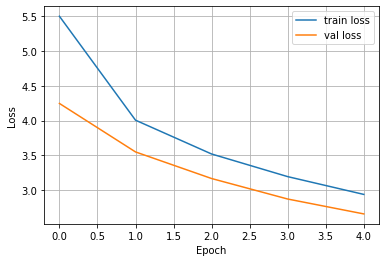

In [11]:
print("min val loss:",min_val_loss)
plt.plot(train_loss_curve)
plt.plot(val_loss_curve)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("train loss","val loss"))
plt.savefig("../images/" + model_name.split(sep="/")[-1] + ".png")
plt.show()

In [12]:
translate(transformer, "eine gruppe von menschen steht vor einem iglu .", de_vocab, en_vocab,de_tokenizer, BOS_IDX, EOS_IDX, device)

' a group of people standing in front of a <unk> . '

## Save the Model

In [ ]:
transformer.eval()
torch.save(transformer, model_name + ".pth.tar")

## Calculate the BLEU Score

In [ ]:
'''load reference'''
with open(test_filepaths[0], 'r', encoding='utf8') as f:
    test_data_ = f.readlines()
    
'''make predictions'''
predictions = []
for data in test_data_:
    temp_trans = translate(transformer, data.lower(), de_vocab, en_vocab, de_tokenizer, BOS_IDX, EOS_IDX, device)
    predictions.append(temp_trans[1:-3]+" . \n")

'''update predictions.txt'''
with open("predictions.txt",'w+') as f:
    f.writelines(predictions)

In [ ]:
'''eliminate <unk>''' 
# for i,pre in enumerate(predictions):
#     predictions[i] = pre.replace("<unk>"," ")
# '''update predictions.txt'''
# with open("predictions.txt",'w+') as f:
#     f.writelines(predictions)

In [13]:
! perl ./multi-bleu.perl -lc reference.txt < predictions.txt

with open(model_name + ".txt",'w+') as f:    
    f.writelines(predictions)

BLEU = 37.14, 70.6/45.7/30.7/21.1 (BP=0.976, ratio=0.977, hyp_len=12752, ref_len=13058)


NameError: name 'predictions' is not defined

In [ ]:
from torchtext.data.metrics import bleu_score
references_corpus  = []
candidate_corpus = []
'''update reference.txt'''
'''update reference.txt'''
with open(test_filepaths[1], 'r', encoding='utf8') as f:
    reference = f.readlines()

for i in range(len(reference)):
    reference[i] = " ".join(en_tokenizer(reference[i])).lower()

for pred,ref in zip(predictions, reference):
    temp = pred.rstrip(" \n").split(" ")
    candidate_corpus.append(temp)
    temp = ref.rstrip(" \n").split(" ")
    references_corpus.append([temp])
bleu_torchtext = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score = {bleu_torchtext*100:.2f}')